In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file_path = "output2.xlsx"
df = pd.read_excel(file_path)

In [3]:
required_columns = ['Country', 'Sector', 2023]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Dataset must contain '{col}' column.")

In [4]:
countries = df['Country']
sectors = df['Sector']
df = df.select_dtypes(include=[np.number])

In [5]:
X = df.drop(columns=[2023])  
y = df[2023]


In [6]:
X_train, X_test, y_train, y_test, countries_train, countries_test, sectors_train, sectors_test = train_test_split(
    X, y, countries, sectors, test_size=0.2, random_state=42
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred_test = lr_model.predict(X_test)

In [10]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [11]:
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
rf_best_model = grid_search.best_estimator_
rf_pred_test = rf_best_model.predict(X_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [12]:
def build_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [13]:
ann_model = build_ann_model((X_train.shape[1],))
ann_model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
ann_pred_test = ann_model.predict(X_test_scaled).flatten()

Epoch 1/100


C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17720.5938 - mae: 14.1239 - val_loss: 3627.3303 - val_mae: 8.0245
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5802.7720 - mae: 6.6744 - val_loss: 1523.9042 - val_mae: 5.2430
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2786.8408 - mae: 5.1855 - val_loss: 1240.3120 - val_mae: 4.6228
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1388.1666 - mae: 4.4773 - val_loss: 1108.3295 - val_mae: 4.1741
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4502.6602 - mae: 4.6505 - val_loss: 712.9819 - val_mae: 3.4218
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5436.5415 - mae: 4.8692 - val_loss: 437.6944 - val_mae: 3.0632
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1733.5690 - mae: 3.3102 - val_loss: 657.0458 - val_mae: 3.6645
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1444.1877 - mae: 4.5677 - val_loss: 242.5463 - val_mae: 2.5868
Epoch 9/100
17

In [14]:
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

In [15]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model


In [16]:
lstm_model = build_lstm_model((1, X_train.shape[1]))
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
lstm_pred_test = lstm_model.predict(X_test_lstm).flatten()

Epoch 1/100


C:\Users\LENOVO\OneDrive\Desktop\Tensorflow\tfenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 21603.6113 - mae: 11.3774 - val_loss: 3503.4954 - val_mae: 8.3601
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15873.4473 - mae: 9.0555 - val_loss: 1894.7285 - val_mae: 6.5230
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22094.5039 - mae: 10.2897 - val_loss: 1276.5731 - val_mae: 5.7005
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1588.7744 - mae: 4.8129 - val_loss: 1064.6638 - val_mae: 5.3277
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5187.9854 - mae: 6.6935 - val_loss: 566.7598 - val_mae: 4.2678
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 822.3160 - mae: 4.2325 - val_loss: 122.0813 - val_mae: 3.0332
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 689.4076 - mae: 3.3312 - val_loss: 63.7714 - val_mae: 2.5303
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 622.1604 - mae: 3.3495 - val_loss: 206.0347 - val_mae: 2.9512
Epoch 9/100
175

In [18]:
ensemble_pred_test = (0.2 * lr_pred_test + 0.3 * rf_pred_test + 0.25 * ann_pred_test + 0.25 * lstm_pred_test)

In [19]:
print("\nTesting Performance:")
print(f"Linear Regression R²: {r2_score(y_test, lr_pred_test):.4f}")
print(f"Random Forest R²: {r2_score(y_test, rf_pred_test):.4f}")
print(f"ANN R²: {r2_score(y_test, ann_pred_test):.4f}")
print(f"LSTM R²: {r2_score(y_test, lstm_pred_test):.4f}")
print(f"Ensemble R²: {r2_score(y_test, ensemble_pred_test):.4f}")


Testing Performance:
Linear Regression R²: 0.9953
Random Forest R²: 0.9377
ANN R²: 0.8590
LSTM R²: 0.8759
Ensemble R²: 0.9921


In [20]:
country_predictions = pd.DataFrame({
    'Country': countries_test.values,
    'Sector': sectors_test.values,
    'Actual_Emission': y_test.values,
    'Predicted_Emission': ensemble_pred_test
})

In [21]:
country_predictions = country_predictions.sort_values(by='Predicted_Emission', ascending=False)
top_10 = country_predictions.head(10)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2876\116153093.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10['Country'] + " - " + top_10['Sector'], y=top_10['Predicted_Emission'], palette="coolwarm")


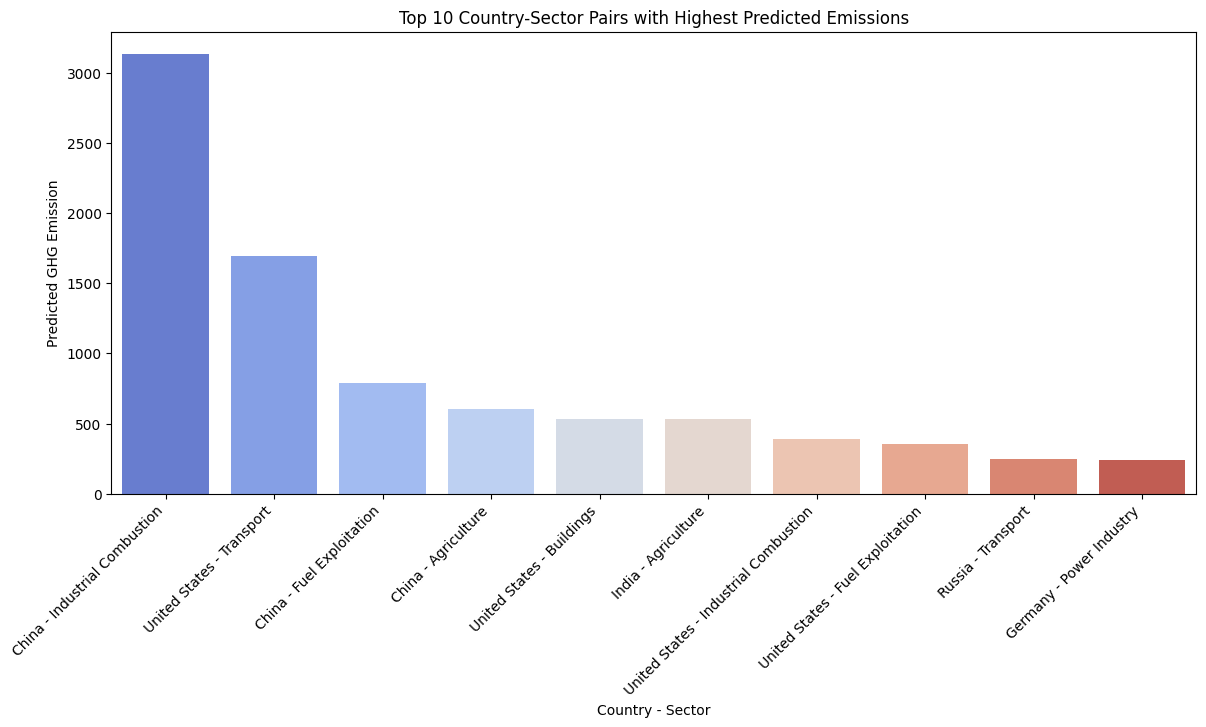

In [22]:
plt.figure(figsize=(14, 6))
sns.barplot(x=top_10['Country'] + " - " + top_10['Sector'], y=top_10['Predicted_Emission'], palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country - Sector")
plt.ylabel("Predicted GHG Emission")
plt.title("Top 10 Country-Sector Pairs with Highest Predicted Emissions")
plt.show()

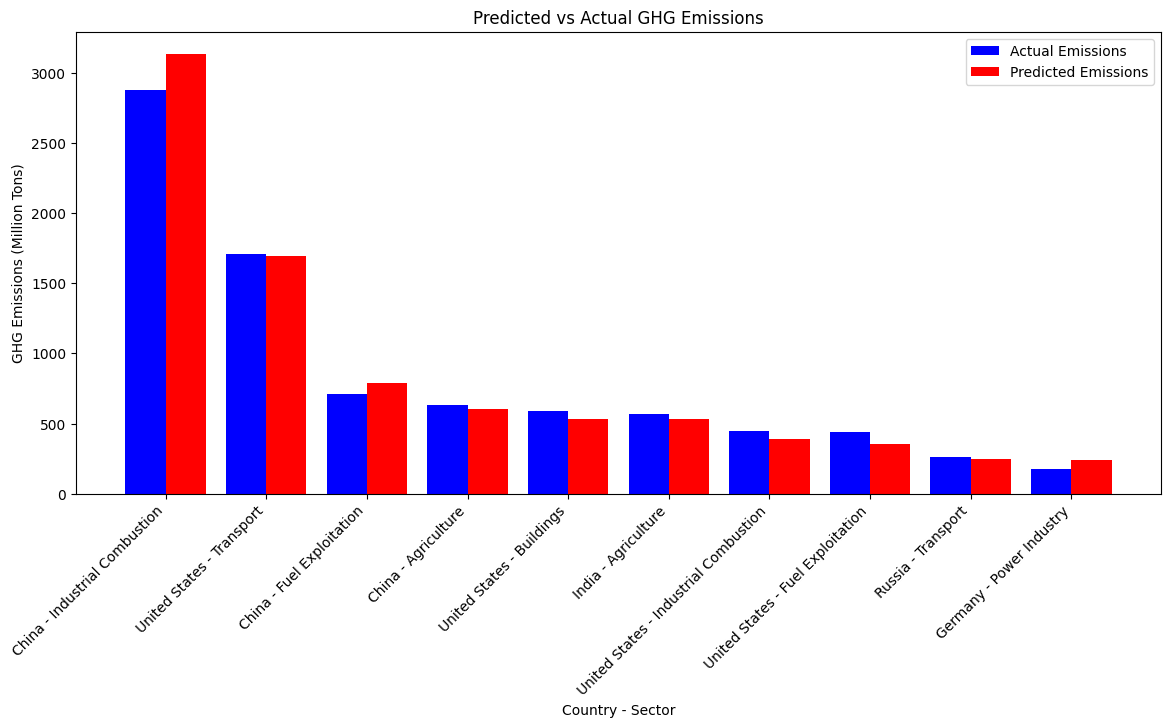

In [23]:
plt.figure(figsize=(14, 6))
bar_width = 0.4
index = np.arange(len(top_10))
plt.bar(index, top_10['Actual_Emission'], bar_width, label="Actual Emissions", color="b")
plt.bar(index + bar_width, top_10['Predicted_Emission'], bar_width, label="Predicted Emissions", color="r")
plt.xlabel("Country - Sector")
plt.ylabel("GHG Emissions (Million Tons)")
plt.title("Predicted vs Actual GHG Emissions")
plt.xticks(index + bar_width / 2, top_10['Country'] + " - " + top_10['Sector'], rotation=45, ha='right')
plt.legend()
plt.show()
